In [2]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Flatten, Input, Dropout
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import shutil
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.metrics import top_k_categorical_accuracy

Using TensorFlow backend.


In [3]:
def spliting_training_and_validation(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct):
    if testing_data_dir.count('/') > 1:
        os.makedirs(testing_data_dir)
        print("Successfully cleaned directory " + testing_data_dir)
    else:
        print("Refusing to delete testing data directory " + testing_data_dir)

    if training_data_dir.count('/') > 1:
        os.makedirs(training_data_dir)
        print("Successfully cleaned directory " + training_data_dir)
    else:
        print("Refusing to delete testing data directory " + training_data_dir)

    num_training_files = 0
    num_testing_files = 0

    for subdir, dirs, files in os.walk(all_data_dir):
        category_name = os.path.basename(subdir)

        # Don't create a subdirectory for the root directory
        if category_name == os.path.basename(all_data_dir):
            continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name

        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)

        for file in files:
            input_file = os.path.join(subdir, file)
            if np.random.rand(1) < testing_data_pct:
                shutil.copy(input_file, testing_data_dir + '/' + category_name + '/' + file)
                num_testing_files += 1
            else:
                shutil.copy(input_file, training_data_dir + '/' + category_name + '/' + file)
                num_training_files += 1

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")
    
    


spliting_training_and_validation('Training','Training_Splitted','Validation',0.4)

Refusing to delete testing data directory Validation
Refusing to delete testing data directory Training_Splitted
Processed 2770 training files.
Processed 1867 testing files.


Found 4558 images belonging to 62 classes.
Found 4347 images belonging to 62 classes.
Found 2520 images belonging to 62 classes.


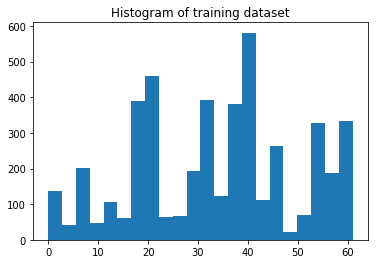

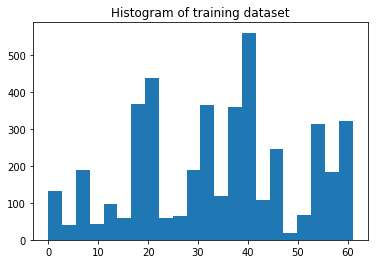

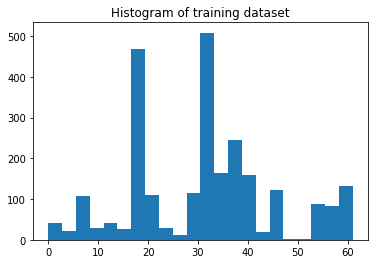

In [4]:
train_data = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_data = ImageDataGenerator(rescale=1. / 255)
test_data = ImageDataGenerator(rescale=1. / 255)

training_set = train_data.flow_from_directory('Training_Splitted', target_size=(64, 64), batch_size=1, class_mode='categorical')
validation_set = train_data.flow_from_directory('Validation', target_size=(64, 64), batch_size=1, class_mode='categorical')
test_set = test_data.flow_from_directory('Testing', target_size=(64, 64), batch_size=1, shuffle = False, class_mode='categorical')

plt.hist(training_set.classes, bins='auto') 
plt.title("Histogram of training dataset")
plt.show()

plt.hist(validation_set.classes, bins='auto') 
plt.title("Histogram of training dataset")
plt.show()

plt.hist(test_set.classes, bins='auto') 
plt.title("Histogram of training dataset")
plt.show()



In [7]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [8]:
x = Sequential()

x.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
x.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
x.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
x.add(MaxPooling2D(pool_size = (2, 2)))
x.add(Dropout(0.25))

x.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
x.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
x.add(MaxPooling2D(pool_size = (2, 2)))
x.add(Dropout(0.25))

x.add(Flatten(input_shape=x.output_shape[1:]))
x.add(Dense(units = 256, activation = 'relu'))
x.add(Dropout(0.5))
x.add(Dense(units = 62, activation = 'softmax'))

x.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy', 'top_k_categorical_accuracy'])

epoch_no=15
hist=x.fit_generator(training_set,steps_per_epoch = 100,epochs = epoch_no,validation_data = validation_set)
x.save('my_classifier.h5')

Epoch 1/15
100/100 [==============================] - 162s 2s/step - loss: 4.6339 - acc: 0.0500 - top_k_categorical_accuracy: 0.1600 - val_loss: 3.8434 - val_acc: 0.0430 - val_top_k_categorical_accuracy: 0.3149
Epoch 2/15
100/100 [==============================] - 158s 2s/step - loss: 4.0352 - acc: 0.0700 - top_k_categorical_accuracy: 0.2200 - val_loss: 3.6556 - val_acc: 0.1546 - val_top_k_categorical_accuracy: 0.3984
Epoch 3/15
100/100 [==============================] - 169s 2s/step - loss: 3.9061 - acc: 0.1000 - top_k_categorical_accuracy: 0.4000 - val_loss: 3.4140 - val_acc: 0.1712 - val_top_k_categorical_accuracy: 0.4934
Epoch 4/15
100/100 [==============================] - 178s 2s/step - loss: 3.7208 - acc: 0.1300 - top_k_categorical_accuracy: 0.3500 - val_loss: 3.5270 - val_acc: 0.1661 - val_top_k_categorical_accuracy: 0.4723
Epoch 5/15
100/100 [==============================] - 194s 2s/step - loss: 3.6688 - acc: 0.2000 - top_k_categorical_accuracy: 0.4000 - val_loss: 3.2622 - va

In [9]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
train_acc_top5 = hist.history['top_k_categorical_accuracy']
val_acc_top5 = hist.history['val_top_k_categorical_accuracy']
xc=range(epoch_no)

In [19]:
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])
plt.savefig("train_loss vs val_loss.png")

In [20]:
plt.figure(2,figsize=(7,5))
plt.plot(xc,val_acc)
plt.plot(xc,train_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['val','train'],loc=4)
plt.style.use(['classic'])
plt.savefig("train_acc vs val_acc.png")

In [21]:
plt.figure()
plt.plot(xc, val_loss, label='val_loss')
plt.plot(xc, train_loss, label='train_loss')
plt.ylabel("categorical_crossentropy")
plt.xlabel("number of epoch")
plt.legend()
plt.savefig("Loss_top5.png")

In [22]:
plt.figure()
plt.plot(xc, val_acc_top5, label='val')
plt.plot(xc, train_acc_top5, label='train')
plt.legend(loc=4)
plt.ylabel("accuracy")
plt.xlabel("number of epoch")
plt.savefig("Accuracy_top5.png")

In [23]:
score = x.evaluate_generator(test_set)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 2.57964681811
Test accuracy: 0.427380952381
